### **Pytorch一般有以下几个流程**


- 1. 数据读取

- 2. 数据处理

- 3. 搭建网络

- 4. 模型训练

- 5. 模型上线

## 1. 数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 在指定GPU运行，比如第一个GPU就是0，如果多个GPU，就是"0,1"

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary


d:\miniconda3\envs\torch11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    # transforms.RandomCrop(32,padding=4), # 数据增广
    # transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [3]:
Batch_Size = 128

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170499072it [01:43, 1655250.57it/s]                               


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 2. 查看数据（格式，大小，形状）

In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [8]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    


 ## 3. 查看图片

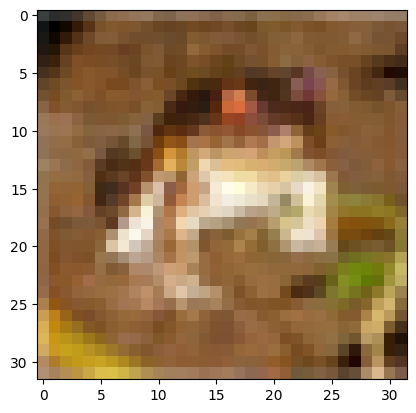

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

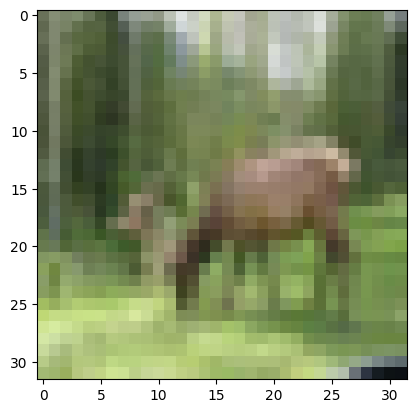

In [11]:
imshow(im[0])

In [12]:
im[0].shape

torch.Size([3, 32, 32])

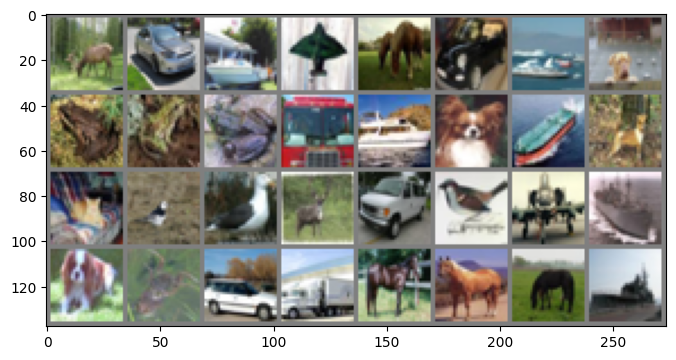

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

## 4. 定义网络（SENet）

## 4. 定义网络（SENet）

我们之前已经学习了 AlexNet，VGGNet，InceptionNet，ResNet，DenseNet等，他们的效果已经被充分验证，而且被广泛的应用在各类计算机视觉任务上。这里我们再学习一个网络（SENet）。Squeeze-and-Excitation Networks（SENet）是由自动驾驶公司Momenta在2017年公布的一种全新的图像识别结构，它通过对特征通道间的相关性进行建模，把重要的特征进行强化来提升准确率。SENet 以极大的优势获得了最后一届 ImageNet 2017 竞赛 Image Classification 任务的冠军，top5的错误率达到了2.251%，比2016年的第一名还要低25%，可谓提升巨大。下面就来具体学习一下SENet。



### SE Block

SE Block是SENet的Block单元，图中的Ftr是传统的卷积结构，X和U是Ftr的输入（C'xH'xW'）和输出（CxHxW），这些都是以往结构中已存在的。SENet增加的部分是U后的结构：对U先做一个Global Average Pooling（图中的Fsq(.)，作者称为Squeeze过程），输出的1x1xC数据再经过两级全连接（图中的Fex(.)，作者称为Excitation过程），最后用sigmoid（论文中的self-gating mechanism）限制到[0，1]的范围，把这个值作为scale乘到U的C个通道上， 作为下一级的输入数据。这种结构的原理是想通过控制scale的大小，把重要的特征增强，不重要的特征减弱，从而让提取的特征指向性更强。

![img](https://img-blog.csdn.net/20180423230918755)

上图是SE 模块的示意图。给定一个输入 x，其特征通道数为 c_1，通过一系列卷积等一般变换后得到一个特征通道数为 c_2 的特征。与传统的 CNN 不一样的是，接下来通过三个操作来重标定前面得到的特征。

首先是 Squeeze 操作，顺着空间维度来进行特征压缩，将每个二维的特征通道变成一个实数，这个实数某种程度上具有全局的感受野，并且输出的维度和输入的特征通道数相匹配。它表征着在特征通道上响应的全局分布，而且使得靠近输入的层也可以获得全局的感受野，这一点在很多任务中都是非常有用的。

其次是 Excitation 操作，它是一个类似于循环神经网络中门的机制。通过参数 w 来为每个特征通道生成权重，其中参数 w 被学习用来显式地建模特征通道间的相关性。

最后是一个 Reweight 的操作，将 Excitation 的输出的权重看做是进过特征选择后的每个特征通道的重要性，然后通过乘法逐通道加权到先前的特征上，完成在通道维度上的对原始特征的重标定。

我们可以总结一下**中心思想**：对于每个输出 channel，预测一个常数权重，对每个 channel 加权一下，本质上，SE模块是在 channel 维度上做 attention 或者 gating 操作，这种注意力机制让模型可以更加关注信息量最大的 channel 特征，而抑制那些不重要的 channel 特征。SENet 一个很大的优点就是可以很方便地集成到现有网络中，提升网络性能，并且代价很小。

### SE模块的应用

这是两个SENet实际应用的例子，左侧是SE-Inception的结构，即Inception模块和SENet组和在一起；右侧是SE-ResNet，ResNet和SENet的组合，这种结构scale放到了直连相加之前。

![img](https://img-blog.csdn.net/20180423233511251)



SE模块可以嵌入到现在几乎所有的网络结构中。通过在原始网络结构的 building block 单元中嵌入 SE模块，我们可以获得不同种类的 SENet。如SE-BN-Inception，SE-ResNet，SE-ReNeXt，SE-Inception-ResNet-v2等等

![img](https://img2020.cnblogs.com/blog/1226410/202101/1226410-20210122143308379-1799927935.png)

从上面的介绍中可以发现，SENet构造非常简单，而且很容易被部署，不需要引入新的函数或者层。除此之外，它还在模型和计算复杂度上具有良好的特性。拿 ResNet-50 和 SE-ResNet-50 对比举例来说，SE-ResNet-50 相对于 ResNet-50有着 10% 模型参数的增长。额外的模型参数都存在于 Bottleneck 设计的两个 Fully Connected 中，由于 ResNet 结构中最后一个 stage 的特征通道数目为 2048，导致模型参数有着较大的增长，实现发现移除掉最后一个 stage 中 3个 build block 上的 SE设定，可以将 10%参数量的增长减少到 2%。此时模型的精度几乎无损失。

![img](https://img2020.cnblogs.com/blog/1226410/202101/1226410-20210122143339705-1444052988.png)

#### 判断是否使用GPU

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        """
        构造函数，初始化BasicBlock模块的各个组件

        :param in_planes: 输入通道数
        :param planes: 输出通道数
        :param stride: 步长
        """
        super(BasicBlock, self).__init__()
        # 第一个卷积层
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # 第二个卷积层
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            # 如果输入输出通道数不同或者步长不为1，则使用1x1卷积层
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)  # Use nn.Conv2d instead of nn.Linear
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Squeeze
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        # Excitation
        out = out * w 

        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [16]:

class PreActBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
            )

        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))

        # Squeeze
        w = F.avg_pool2d(out, int(out.size(2)))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        # Excitation
        out = out * w

        out += shortcut
        return out


In [17]:

class SENet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SENet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def SENet18(num_classes=10):
    return SENet(PreActBlock, [2,2,2,2], num_classes=num_classes)



In [18]:
net = SENet18(num_classes=10).to(device)

In [19]:
summary(net,(3,32,32))

d:\miniconda3\envs\torch11\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,864
            Conv2d-7              [-1, 4, 1, 1]             260
            Conv2d-8             [-1, 64, 1, 1]             320
       PreActBlock-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 64, 32, 32]          36,864
           Conv2d-14              [-1, 

In [20]:
print(net)

SENet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [21]:
test_x = torch.randn(2,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([2, 10])


In [22]:
net = SENet18(num_classes=10).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

## 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
    
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


In [23]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94 ,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 20

## 6. 训练及可视化（增加TensorBoard可视化）

In [24]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/SENet.pth'

文件已存在


这次更新了tensorboard的可视化，可以得到更好看的图片，并且能可视化出不错的结果

In [25]:
# 使用tensorboard
from torch.utils.tensorboard import SummaryWriter
os.makedirs("./logs", exist_ok=True)
tbwriter = SummaryWriter(log_dir='./logs/SENet18', comment='SENet18')  # 使用tensorboard记录中间输出
tbwriter.add_graph(model= net, input_to_model=torch.randn(size=(1, 3, 32, 32)))

/tmp/ipykernel_2614327/2857566879.py:25: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  w = F.avg_pool2d(out, int(out.size(2)))
/home/dkj/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [26]:
from utils import plot_history
from utils import train
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, tbwriter, verbose = True)

Test Epoch 1/20: 100%|██████████| 78/78 [00:01<00:00, 64.03it/s, Test Acc=0.546, Test Loss=1.28]


Epoch [  1/ 20]  Train Loss:1.444286  Train Acc:46.98% Test Loss:1.276667  Test Acc:54.61%  Learning Rate:0.100000


Test Epoch 2/20: 100%|██████████| 78/78 [00:01<00:00, 60.01it/s, Test Acc=0.663, Test Loss=0.986]


Epoch [  2/ 20]  Train Loss:0.878925  Train Acc:68.59% Test Loss:0.986204  Test Acc:66.26%  Learning Rate:0.100000


Test Epoch 3/20: 100%|██████████| 78/78 [00:01<00:00, 63.16it/s, Test Acc=0.771, Test Loss=0.649]


Epoch [  3/ 20]  Train Loss:0.657689  Train Acc:77.20% Test Loss:0.648814  Test Acc:77.06%  Learning Rate:0.100000


Test Epoch 4/20: 100%|██████████| 78/78 [00:01<00:00, 61.96it/s, Test Acc=0.762, Test Loss=0.697]


Epoch [  4/ 20]  Train Loss:0.532490  Train Acc:81.67% Test Loss:0.696845  Test Acc:76.20%  Learning Rate:0.100000


Test Epoch 5/20: 100%|██████████| 78/78 [00:01<00:00, 63.10it/s, Test Acc=0.785, Test Loss=0.642]


Epoch [  5/ 20]  Train Loss:0.459192  Train Acc:84.09% Test Loss:0.641512  Test Acc:78.46%  Learning Rate:0.100000


Test Epoch 6/20: 100%|██████████| 78/78 [00:01<00:00, 61.06it/s, Test Acc=0.792, Test Loss=0.606]


Epoch [  6/ 20]  Train Loss:0.405891  Train Acc:86.11% Test Loss:0.605668  Test Acc:79.21%  Learning Rate:0.100000


Test Epoch 7/20: 100%|██████████| 78/78 [00:01<00:00, 60.71it/s, Test Acc=0.756, Test Loss=0.733]


Epoch [  7/ 20]  Train Loss:0.361291  Train Acc:87.53% Test Loss:0.732757  Test Acc:75.64%  Learning Rate:0.100000


Test Epoch 8/20: 100%|██████████| 78/78 [00:01<00:00, 58.71it/s, Test Acc=0.729, Test Loss=0.913]


Epoch [  8/ 20]  Train Loss:0.334168  Train Acc:88.33% Test Loss:0.913161  Test Acc:72.88%  Learning Rate:0.100000


Test Epoch 9/20: 100%|██████████| 78/78 [00:01<00:00, 60.32it/s, Test Acc=0.711, Test Loss=0.933]


Epoch [  9/ 20]  Train Loss:0.306639  Train Acc:89.53% Test Loss:0.933174  Test Acc:71.12%  Learning Rate:0.100000


Test Epoch 10/20: 100%|██████████| 78/78 [00:01<00:00, 59.58it/s, Test Acc=0.8, Test Loss=0.624]  


Epoch [ 10/ 20]  Train Loss:0.288383  Train Acc:89.77% Test Loss:0.623786  Test Acc:80.00%  Learning Rate:0.100000


Test Epoch 11/20: 100%|██████████| 78/78 [00:01<00:00, 61.92it/s, Test Acc=0.797, Test Loss=0.651]


Epoch [ 11/ 20]  Train Loss:0.269391  Train Acc:90.69% Test Loss:0.651273  Test Acc:79.69%  Learning Rate:0.100000


Test Epoch 12/20: 100%|██████████| 78/78 [00:01<00:00, 62.66it/s, Test Acc=0.758, Test Loss=0.799]


Epoch [ 12/ 20]  Train Loss:0.262791  Train Acc:90.85% Test Loss:0.798698  Test Acc:75.84%  Learning Rate:0.100000


Test Epoch 13/20: 100%|██████████| 78/78 [00:01<00:00, 62.38it/s, Test Acc=0.814, Test Loss=0.572]


Epoch [ 13/ 20]  Train Loss:0.248744  Train Acc:91.29% Test Loss:0.572026  Test Acc:81.42%  Learning Rate:0.100000


Test Epoch 14/20: 100%|██████████| 78/78 [00:01<00:00, 60.12it/s, Test Acc=0.79, Test Loss=0.683] 


Epoch [ 14/ 20]  Train Loss:0.235874  Train Acc:91.90% Test Loss:0.683216  Test Acc:79.03%  Learning Rate:0.100000


Test Epoch 15/20: 100%|██████████| 78/78 [00:01<00:00, 61.41it/s, Test Acc=0.783, Test Loss=0.776]


Epoch [ 15/ 20]  Train Loss:0.223898  Train Acc:92.26% Test Loss:0.776317  Test Acc:78.34%  Learning Rate:0.100000


Test Epoch 16/20: 100%|██████████| 78/78 [00:01<00:00, 62.00it/s, Test Acc=0.758, Test Loss=0.818]


Epoch [ 16/ 20]  Train Loss:0.225781  Train Acc:92.20% Test Loss:0.818387  Test Acc:75.76%  Learning Rate:0.100000


Test Epoch 17/20: 100%|██████████| 78/78 [00:01<00:00, 60.83it/s, Test Acc=0.764, Test Loss=0.872]


Epoch [ 17/ 20]  Train Loss:0.211836  Train Acc:92.71% Test Loss:0.872311  Test Acc:76.35%  Learning Rate:0.100000


Test Epoch 18/20: 100%|██████████| 78/78 [00:01<00:00, 62.29it/s, Test Acc=0.761, Test Loss=0.818]


Epoch [ 18/ 20]  Train Loss:0.209121  Train Acc:92.87% Test Loss:0.818234  Test Acc:76.09%  Learning Rate:0.100000


Test Epoch 19/20: 100%|██████████| 78/78 [00:01<00:00, 59.10it/s, Test Acc=0.764, Test Loss=0.8]  


Epoch [ 19/ 20]  Train Loss:0.210039  Train Acc:92.76% Test Loss:0.799828  Test Acc:76.42%  Learning Rate:0.100000


Test Epoch 20/20: 100%|██████████| 78/78 [00:01<00:00, 60.36it/s, Test Acc=0.772, Test Loss=0.775]

Epoch [ 20/ 20]  Train Loss:0.206847  Train Acc:92.89% Test Loss:0.775048  Test Acc:77.22%  Learning Rate:0.100000


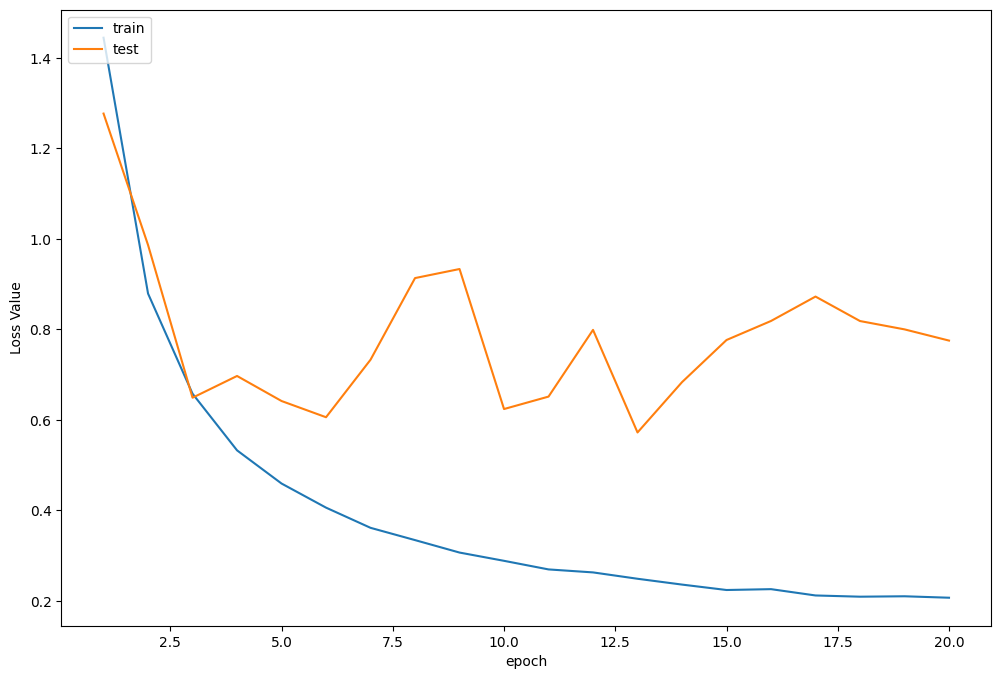

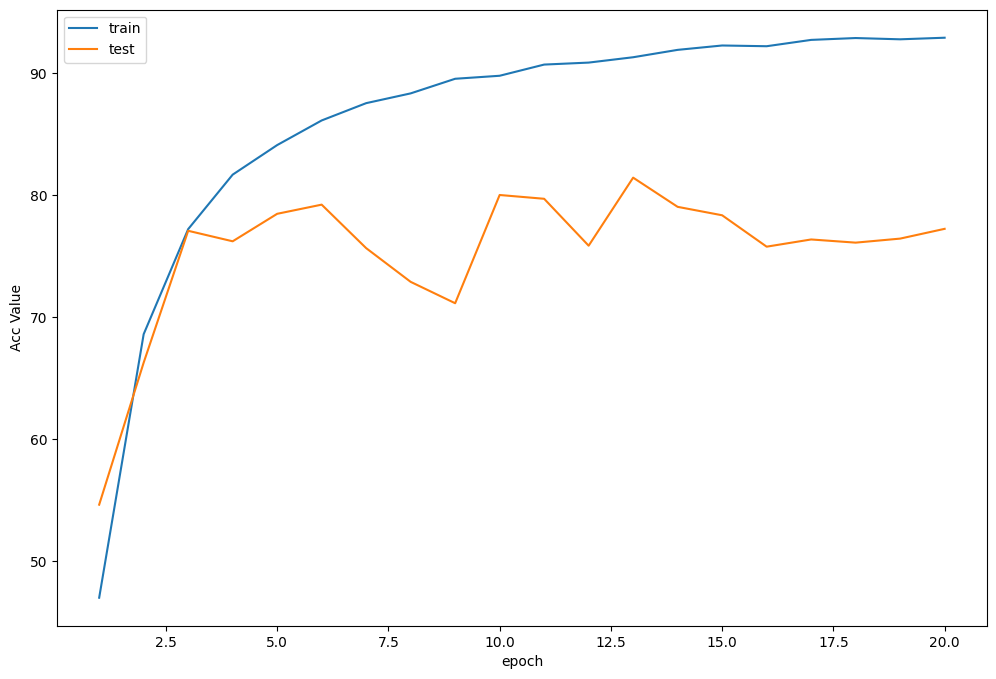

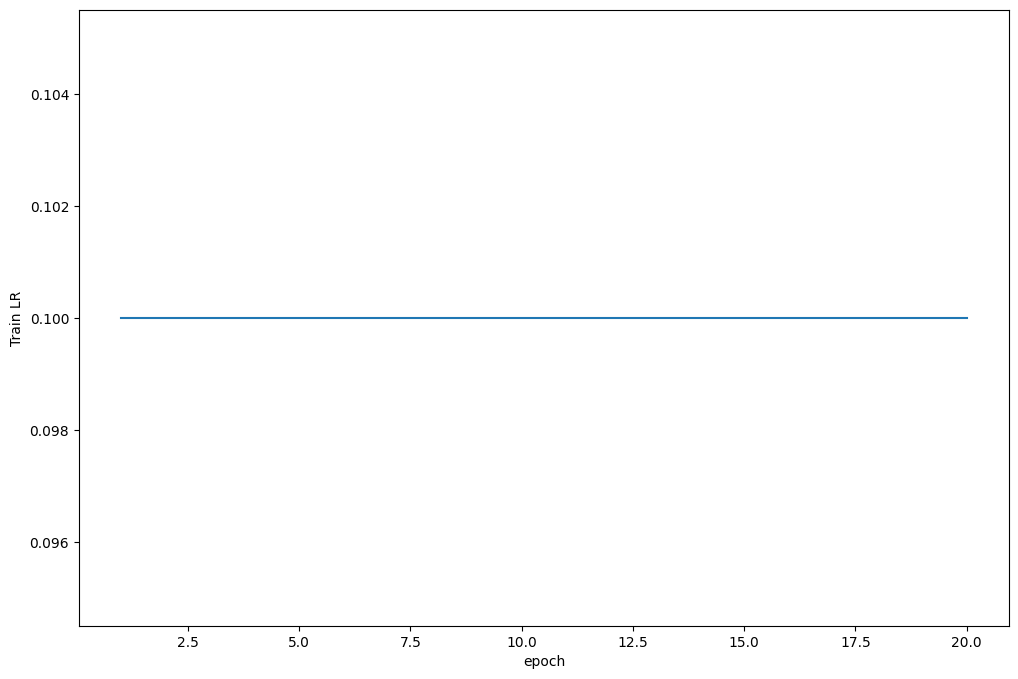

In [27]:
plot_history(epoch ,Acc, Loss, Lr)

In [28]:
# %reload_ext tensorboard
# %tensorboard --logdir './log'

## 7. 测试

In [29]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 77.23 %


程序中的 `torch.max(outputs.data, 1)` ，返回一个tuple (元组)

而这里很明显，这个返回的元组的第一个元素是image data，即是最大的 值，第二个元素是label， 即是最大的值 的 索引！我们只需要label（最大值的索引），所以就会有` _ `,predicted这样的赋值语句，表示忽略第一个返回值，把它赋值给` _`， 就是舍弃它的意思；

In [30]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 90.07 %
Accuracy of automobile : 90.88 %
Accuracy of  bird : 53.56 %
Accuracy of   cat : 54.05 %
Accuracy of  deer : 70.97 %
Accuracy of   dog : 72.17 %
Accuracy of  frog : 88.09 %
Accuracy of horse : 70.44 %
Accuracy of  ship : 93.89 %
Accuracy of truck : 88.00 %


Accuracy Rate = 81.25%


<Figure size 2500x400 with 0 Axes>

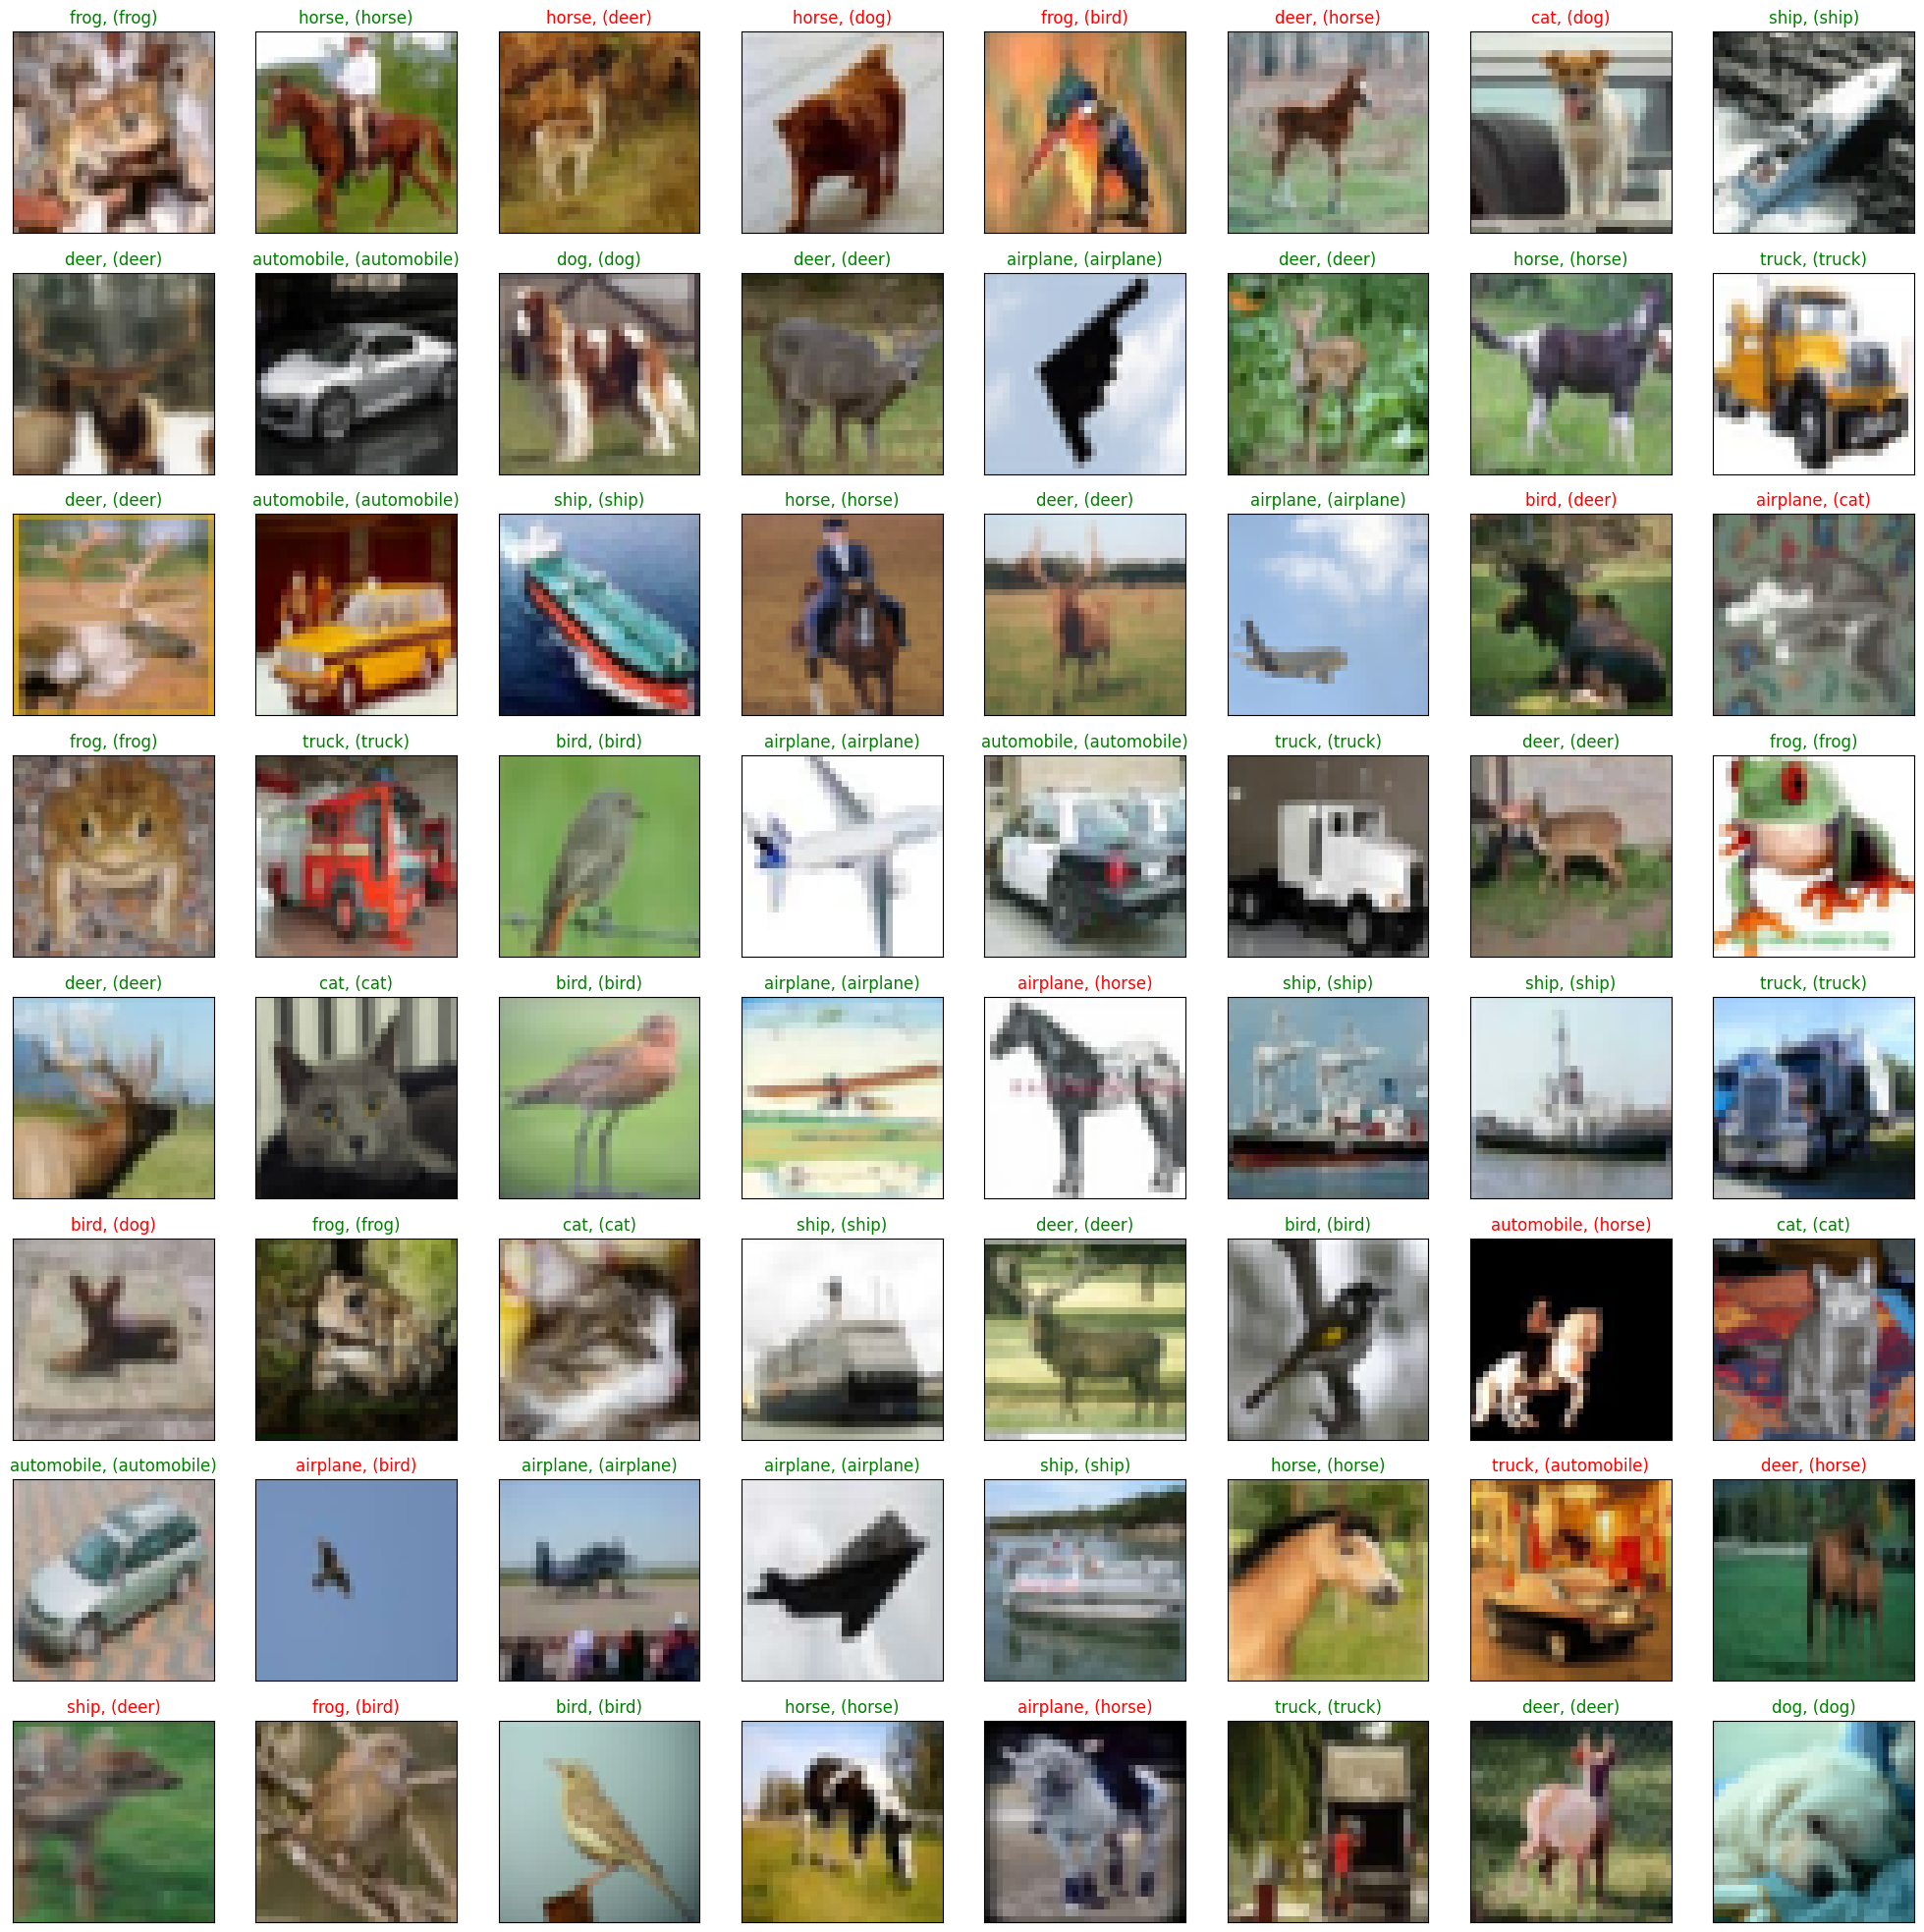

In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

## 8. 保存模型

In [32]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')

## 9. 预测

In [25]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SENet18(num_classes=10)

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

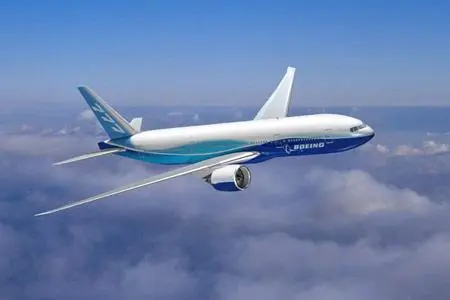

In [34]:
img

In [35]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[9.9239e-01, 2.1051e-05, 7.0973e-05, 2.2179e-06, 2.0383e-06, 1.1027e-07,
         1.9355e-06, 5.0448e-08, 7.4134e-03, 1.0011e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 0
tensor([10.6461], device='cuda:0')
分类 plane


<Response [200]>


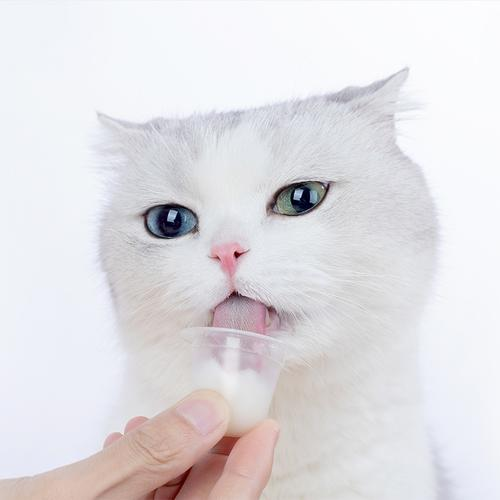

In [37]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
# url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
# url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
# url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [38]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[0.5546, 0.0017, 0.1146, 0.1129, 0.0331, 0.1359, 0.0067, 0.0070, 0.0271,
         0.0064]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
类别 0
tensor([2.9417], device='cuda:0')
分类 plane
